<a href="https://colab.research.google.com/github/call493/MLFC/blob/main/Poverty_and_Literacy_levels_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the link between literacy rates and poverty in Kenya - A Socio-Economic Analysis**



---



Braxton Mandara, DSAIL

15-09-2025

# **Step 1: Initial Setup**

Installing Python packages which we will use to download, model and analyze map features and other spatial data from OpenStreetMap.

In [ ]:
%%capture
%pip install osmnx

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import warnings
import math
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning, module='osmnx')

# **Step 2 : Plot map of Kenya**

Plotting map of Kenya

In [ ]:
!git clone https://github.com/call493/fynesse.git
import sys
sys.path.append("/content/fynesse")

fatal: destination path 'fynesse' already exists and is not an empty directory.


In [ ]:
import fynesse

In [ ]:
fynesse.access.plot_map("Kenya")

Let us proceed to plot the county boundaries.

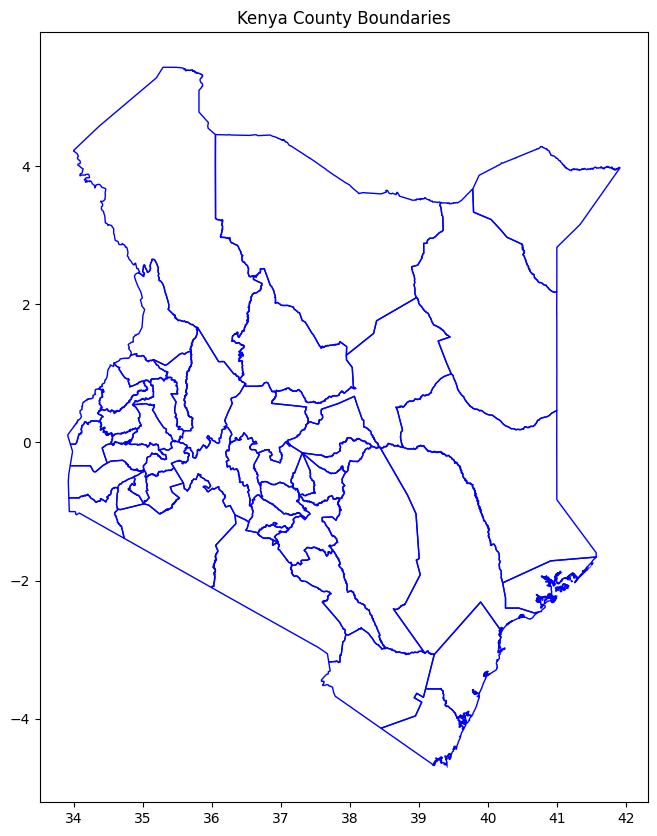

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

# URL to the GeoJSON file for Kenyan counties (ADM1) from GeoBoundaries
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

kenya_gdf = gpd.read_file(geojson_url)

fig, ax = plt.subplots(figsize=(10, 10))
kenya_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

ax.set_title("Kenya County Boundaries")

plt.show()

# **Step 3 : Schools distribution in different counties**

I proceed to look at how primary schools are distributed in the country using the school geolocation (coordinates) data from schools.json file which has details for Kenyan schools in the year 2020. This dataset was obtained from Energydata ---> https://energydata.info/dataset/kenya-schools#

In [ ]:
fynesse.assess.plot_primary_schools(
    schools_file="https://raw.githubusercontent.com/call493/MLFC/main/schools.json",
    geojson_url="https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"
)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

schools_file = "https://raw.githubusercontent.com/call493/MLFC/main/schools.json"

geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# County boundaries
kenya_gdf = gpd.read_file(geojson_url)

# Load schools data
schools_gdf = gpd.read_file(schools_file)

# Reproject schools to match counties
schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)

# Distinguish public and private schools
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

fig, ax = plt.subplots(figsize=(12, 12))
kenya_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

public_schools.plot(ax=ax, color="blue", markersize=1, label="Public Schools")
private_schools.plot(ax=ax, color="red", markersize=1, label="Private Schools")

ax.set_title("Primary Schools in Kenya (Public vs Private)", fontsize=12)
ax.legend()

plt.show()

## Let us look at data for primary schools and secondary schools

How are primary schools and secondary schools distributed across the country in different counties.

In [ ]:
fynesse.assess.plot_schools_on_county_boundaries()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import zipfile

# Shapefile ZIP URL (for both primary and secondary schools)
schools_zip_url = "https://github.com/call493/MLFC/raw/main/schools.zip"
local_zip_path = "schools.zip"
extracted_dir = "schools_extracted"

# County boundaries
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"

# Load counties
kenya_gdf = gpd.read_file(geojson_url)

# Download the zip file
print(f"Downloading {schools_zip_url}...")
response = requests.get(schools_zip_url)
response.raise_for_status() # Raise an exception for bad status codes
with open(local_zip_path, 'wb') as f:
    f.write(response.content)
print(f"Downloaded to {local_zip_path}")

# Extract the zip file
print(f"Extracting {local_zip_path}...")
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
print(f"Extracted to {extracted_dir}")

# Find the shapefile (.shp) in the extracted directory
shp_file = None
for root, _, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".shp"):
            shp_file = os.path.join(root, file)
            break
    if shp_file:
        break

if shp_file:
    print(f"Shapefile found at: {shp_file}")
    # Load all school points from the shapefile
    all_schools_gdf = gpd.read_file(shp_file)

    # Reproject schools to match counties
    all_schools_gdf = all_schools_gdf.to_crs(kenya_gdf.crs)

    primary_schools = all_schools_gdf[all_schools_gdf["LEVEL"].str.lower() == "primary"]
    secondary_schools = all_schools_gdf[all_schools_gdf["LEVEL"].str.lower() == "secondary"]

    fig, ax = plt.subplots(figsize=(12, 12))
    kenya_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.8)

    if not primary_schools.empty:
        primary_schools.plot(ax=ax, color="green", markersize=5, label="Primary Schools")
    if not secondary_schools.empty:
        secondary_schools.plot(ax=ax, color="blue", markersize=5, label="Secondary Schools")

    ax.set_title("Schools in Kenya (Primary vs Secondary)", fontsize=12)
    ax.legend()
    plt.show()
else:
    print("Shapefile (.shp) not found in the extracted directory.")

From the look of things, there are more primary schools than secondary schools, we will be proving that in the following cells.

## Obtain and Prepare Population Data

The Kenya National Bureau of Statistics (KNBS) provides population data. I will search for the 2019 Census data which includes population counts by county. I will use the data from the following source:

https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Volume-1-Population-By-County-And-Sub-County.pdf

Specifically, the 2019 Kenya Population and Housing Census results. I will look for data at the county level. The dataset used here was extracted from the PDF containing the population census report (page 7).

In [ ]:
import pandas as pd
import os

population_file_url = "https://raw.githubusercontent.com/call493/MLFC/main/kenya_population_by_county_2019.csv"

try:
    population_df = pd.read_csv(population_file_url)
    print("Population data loaded successfully!")
    display(population_df.head())
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

### Merge Population Data with County Boundaries

Now, I will merge the population data with the county boundaries GeoDataFrame. I will use the 'County' column in the population DataFrame and the 'ADM1NAME' column in the county GeoDataFrame as the common key for merging. I will perform a left merge to keep all the county geometries and add the population data where a match is found.

In [ ]:
# It's important to check if the county names match exactly in both dataframes.
# Let's print the unique county names from both dataframes to compare.
print("Unique counties in population_df:")
print(population_df['County'].unique())

print("\nColumns in kenya_gdf:")
print(kenya_gdf['shapeName'].unique())

The names do not match, let us see the output we will get when we plot a population heatmap

### Population Heatmap by County

This heatmap visualizes the population distribution across Kenyan counties based on the 2019 census data. Counties with higher populations are shown in darker shades, while those with lower populations are in lighter shades.

In [ ]:
fynesse.assess.plot_population_heatmap(kenya_gdf, population_df)

In [ ]:
# Normalize county names for matching
population_df["County"] = population_df["County"].str.strip().str.upper()
kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

# Merge population with county boundaries
merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()


Same map but for interactivity using follium

In [ ]:
fynesse.assess.plot_interactive_population_map(kenya_gdf, population_df)

In [ ]:
# m = plot_interactive_population_map(kenya_gdf, population_df)
# m  # Display the map in Jupyter/Colab

In [ ]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import pandas as pd

population_df["County"] = population_df["County"].str.strip().str.upper()
kenya_gdf["shapeName"] = kenya_gdf["shapeName"].str.strip().str.upper()

merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

kenya_center = [0.0236, 37.9062]

geojson_data = merged.to_json()

m = folium.Map(location=kenya_center, zoom_start=6, tiles='cartodbpositron')

folium.Choropleth(
    geo_data=geojson_data,
    data=merged,
    columns=["shapeName", "Total"],  # 'Total' is population
    key_on="feature.properties.shapeName",
    fill_color="OrRd",
    fill_opacity=1,
    line_opacity=0.1,
    legend_name="Population (2019)"
).add_to(m)

folium.GeoJson(
    geojson_data,
    name="County Boundaries",
    tooltip=folium.GeoJsonTooltip(fields=["shapeName", "Total"],
                                  aliases=["County:", "Population:"])
).add_to(m)

m

From the look of things we are do not have population data for the following counties: Elgeyo Marakwet, Tharaka Nithi, Taita Taveta and Nairobi.

Why is that?

> The population datadata and the GeoDataFrame have different column names for these counties.

In that case we have to normalize to ensure that the merge works and we have a heatmap that covers data for all counties.



In [ ]:
print(population_df['County'].unique())

Let us use assess county name function.

In [ ]:
from fynesse.assess import normalize_county_names  # Or adjust import if necessary

# Apply to population DataFrame
population_df['County'] = population_df['County'].apply(normalize_county_names)

# Apply to geodataframe
kenya_gdf['shapeName'] = kenya_gdf['shapeName'].apply(normalize_county_names)

merged = kenya_gdf.merge(population_df, left_on='shapeName', right_on='County', how='left')


In [ ]:
fynesse.assess.check_county_mismatches(kenya_gdf, population_df, merged)

In [ ]:
# Check for any remaining mismatches
pop_counties = set(population_df['County'].unique())
geo_counties = set(kenya_gdf['shapeName'].unique())

print(f"\nPopulation counties: {len(pop_counties)}")
print(f"Geographic counties: {len(geo_counties)}")
print(f"\nCounties in population data but not in geographic data: {pop_counties - geo_counties}")
print(f"Counties in geographic data but not in population data: {geo_counties - pop_counties}")

# Check for missing data
missing = merged[merged["Total"].isna()][["shapeName"]]
print(f"\nCounties with missing population data: {len(missing)}")
if len(missing) > 0:
    print(missing)

In [ ]:
print("Unique counties in population_df:")
print(population_df['County'].unique())

Now let us check to confirm that the data has been normalized.

In [ ]:
fynesse.assess.plot_county_population_heatmap(merged)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(
    column="Total",          # population column
    cmap="OrRd",             # color scheme (Orange-Red)
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("2019 Kenya Population Distribution by County", fontsize=16)
ax.axis("off")

plt.show()

#works perfect

Let us proceed to make a comparison between the number of primary schools and secondary schools in each county.

In [ ]:
fynesse.assess.plot_primary_vs_secondary_schools(all_schools_gdf)

In [ ]:
import plotly.express as px

counts = all_schools_gdf.groupby(['County', 'LEVEL']).size().unstack(fill_value=0).reset_index()

fig = px.scatter(
    counts,
    x='Primary',
    y='Secondary',
    text='County',
    hover_name='County',
    labels={'Primary': 'Primary', 'Secondary': 'Secondary'},
    title='Primary vs Secondary Schools by County in Kenya',
)

fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.update_traces(textposition='top right')
fig.update_layout(showlegend=False)
fig.show()


In [ ]:
import plotly.express as px

counts = all_schools_gdf.groupby(['County', 'LEVEL']).size().unstack(fill_value=0).reset_index()

fig = px.scatter(
    counts,
    x='Primary',
    y='Secondary',
    hover_name='County',
    labels={'Primary': 'Number of Primary Schools', 'Secondary': 'Number of Secondary Schools'},
    title='Primary vs Secondary Schools by County in Kenya',
)

fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.update_layout(showlegend=False)
fig.show()


Same distribution on a map

In [ ]:
# from fynesse.assess import normalize_county_names
# m = plot_schools_choropleth_map(normalize_func=normalize_county_names)
# m  # displays the map in Colab/Jupyter

In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import zipfile
import requests
import os

schools_zip_url = "https://github.com/call493/MLFC/raw/main/schools.zip"
local_zip_path = "schools.zip"
extracted_dir = "schools_extracted"

response = requests.get(schools_zip_url)
with open(local_zip_path, "wb") as f:
    f.write(response.content)
with zipfile.ZipFile(local_zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

shp_file = None
for root, _, files in os.walk(extracted_dir):
    for file in files:
        if file.endswith(".shp"):
            shp_file = os.path.join(root, file)
            break
    if shp_file:
        break

all_schools_gdf = gpd.read_file(shp_file)
geojson_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/KEN/ADM1/geoBoundaries-KEN-ADM1.geojson"
kenya_gdf = gpd.read_file(geojson_url)
all_schools_gdf = all_schools_gdf.to_crs(kenya_gdf.crs)

from fynesse.assess import normalize_county_names

all_schools_gdf['County'] = all_schools_gdf['County'].apply(normalize_county_names)
kenya_gdf['shapeName'] = kenya_gdf['shapeName'].apply(normalize_county_names)

school_counts = all_schools_gdf.groupby(['County', 'LEVEL']).size().unstack(fill_value=0)

kenya_gdf = kenya_gdf.merge(school_counts, how='left', left_on='shapeName', right_index=True)
kenya_gdf["Primary"] = kenya_gdf["Primary"].fillna(0).astype(int)
kenya_gdf["Secondary"] = kenya_gdf["Secondary"].fillna(0).astype(int)

m = folium.Map(location=[0.2, 37.5], zoom_start=6)  # Centered for Kenya

folium.Choropleth(
    geo_data=kenya_gdf,
    name='Primary Schools',
    data=kenya_gdf,
    columns=['shapeName', 'Primary'],
    key_on='feature.properties.shapeName',
    fill_color='Greens',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name='Number of Primary Schools'
).add_to(m)

folium.Choropleth(
    geo_data=kenya_gdf,
    name='Secondary Schools',
    data=kenya_gdf,
    columns=['shapeName', 'Secondary'],
    key_on='feature.properties.shapeName',
    fill_color='Blues',
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name='Number of Secondary Schools'
).add_to(m)

folium.GeoJson(
    kenya_gdf,
    name="Counties",
    style_function=lambda x: {'fillColor': '#00000000', 'color': 'black', 'weight': 1},
    tooltip=folium.GeoJsonTooltip(
        fields=['shapeName', 'Primary', 'Secondary'],
        aliases=['County', 'Primary Schools', 'Secondary Schools']),
).add_to(m)

folium.LayerControl().add_to(m)
m.save("schools_counties.html")
m


### Combined Map: Population Heatmap and Schools

This map visualizes the population distribution across Kenyan counties as a heatmap, along with the locations of public and private schools.

In [ ]:
fynesse.assess.plot_population_with_school_locations(kenya_gdf, population_df, schools_gdf)

In [ ]:
merged = kenya_gdf.merge(population_df, left_on="shapeName", right_on="County", how="left")

schools_gdf = schools_gdf.to_crs(kenya_gdf.crs)
public_schools = schools_gdf[schools_gdf["Status"] == "Public"]
private_schools = schools_gdf[schools_gdf["Status"] == "Private"]

fig, ax = plt.subplots(figsize=(16, 16))

# Plot population heatmap
merged.plot(
    column="Total",
    cmap="YlOrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    alpha=0.8,
    legend_kwds={'label': "Population (2019)", 'orientation': "vertical", 'shrink': 0.6}
)

# Overlay schools
public_schools.plot(ax=ax, color="blue", markersize=4, label="Public Schools", alpha=0.7)
private_schools.plot(ax=ax, color="red", markersize=4, label="Private Schools", alpha=0.7)

ax.set_title(
    "Kenya: Population Distribution (2019) with School Locations\nPublic vs Private Schools Overlay",
    fontsize=18, fontweight='bold', pad=20
)
ax.axis("off")
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))

total_public = len(public_schools)
total_private = len(private_schools)
stats_text = f"Total Schools:\nPublic: {total_public:,}\nPrivate: {total_private:,}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

print(f"\n=== COMBINED HEATMAP SUMMARY ===")
print(f"Total counties visualized: {len(merged)}")
print(f"Public schools plotted: {total_public:,}")
print(f"Private schools plotted: {total_private:,}")
print(f"Total schools: {total_public + total_private:,}")
print(f"Total population (2019): {merged['Total'].sum():,.0f}")
print(f"Average population per county: {merged['Total'].mean():,.0f}")


[https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Analytical-Report-on-Education-and-Training.pdf](https://www.knbs.or.ke/wp-content/uploads/2023/09/2019-Kenya-population-and-Housing-Census-Analytical-Report-on-Education-and-Training.pdf)


From the heatmap with school locations we can see that:

*   Certain regions can easily access schools more than other places because of the availability of schools.
*   Regions with high populations have more schools than areas with low population.

Having access to schools does not automatically mean that people will enrol to these institutions and complete successfully.


# Literacy In Kenya

According to UNESCO https://www.theglobaleconomy.com/Kenya/Literacy_rate/ Kenya's literacy rate is at 82.88%.

To bring things into proper perspective, basic literacy can be defined as the ability to both read and write with understanding a short, simple statement about everyday life in English or Kiswahili.

The dataset I used here I obtained it from

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/call493/MLFC/main/kenya_literacy_2019.csv')
display(df.head())

Data used here was obtained from Kenya Poverty Report 2019 https://www.knbs.or.ke/wp-content/uploads/2023/09/The-Kenya-Poverty-Report-2019.pdf

In [ ]:
# Load the poverty rate dataset
import pandas as pd

# Load poverty data from the specified URL
poverty_df = pd.read_csv('https://raw.githubusercontent.com/call493/MLFC/main/kenya_poverty_2019.csv')
print("Poverty data loaded successfully!")
print(f"Poverty dataset shape: {poverty_df.shape}")
print(f"Poverty dataset columns: {poverty_df.columns.tolist()}")
display(poverty_df.head())

In [ ]:
# Merge poverty_df with the previously loaded literacy dataset
# First, let's examine both dataframes and ensure proper column names
print("Columns in poverty_df:", poverty_df.columns.tolist())
print("Columns in df (literacy):", df.columns.tolist())

In [ ]:
# Check county names to identify any inconsistencies
print("\nCounties in poverty_df:")
print(sorted(poverty_df['County'].unique()))
print("\nCounties in literacy df:")
print(sorted(df['County'].unique()))

In [ ]:
# Clean and normalize county names for merging
poverty_df['County'] = poverty_df['County'].str.strip().str.title()
df['County'] = df['County'].str.strip().str.title()

# Merge dataframes on County column
merged_df = pd.merge(df, poverty_df, on='County', how='outer', indicator=True)

print("\nMerged dataframe shape:", merged_df.shape)
print("\nMerged dataframe columns:", merged_df.columns.tolist())
display(merged_df.head())

# Check for missing or mismatched counties
left_only = merged_df[merged_df['_merge'] == 'left_only']
right_only = merged_df[merged_df['_merge'] == 'right_only']
both = merged_df[merged_df['_merge'] == 'both']

print(f"\nCounties in literacy data only (missing in poverty data): {len(left_only)}")
if len(left_only) > 0:
    print(left_only[['County']])

print(f"\nCounties in poverty data only (missing in literacy data): {len(right_only)}")
if len(right_only) > 0:
    print(right_only[['County']])

print(f"\nCounties successfully merged: {len(both)}")

# Diagnostic: Check for counties with missing data from either dataset
missing_data_counties = merged_df[merged_df.isna().any(axis=1)]
print(f"\nCounties with missing data after merge: {len(missing_data_counties)}")
if len(missing_data_counties) > 0:
    print(missing_data_counties[['County', '_merge']])

In [ ]:
final_df = merged_df[merged_df['_merge'] == 'both'].copy()
final_df = final_df.drop(columns=['_merge'])

print(f"Final dataset shape: {final_df.shape}")
print(f"Final dataset columns: {final_df.columns.tolist()}")

# Display statistics for final merged dataset
print("\n=== MERGED DATASET SUMMARY ===")
print(f"Counties successfully merged: {len(final_df)}")
print(f"Literacy Rate - Mean: {final_df['Literacy_Rate_Percent'].mean():.1f}%, Std: {final_df['Literacy_Rate_Percent'].std():.1f}%")
print(f"Poverty Rate - Mean: {final_df['Headcount_Rate_Percent'].mean():.1f}%, Std: {final_df['Headcount_Rate_Percent'].std():.1f}%")

# Display the cleaned merged dataframe
display(final_df.head())

# Check for any remaining missing values
missing_vals = final_df.isnull().sum()
print("\nMissing values per column:")
for col in final_df.columns:
    if missing_vals[col] > 0:
        print(f"{col}: {missing_vals[col]}")

if missing_vals.sum() == 0:
    print("No missing values in the final dataset!")

# Save cleaned merged dataset for correlation analysis
final_df.to_csv('poverty_literacy_merged_clean_2019.csv', index=False)
print("\nCleaned merged dataset saved as 'poverty_literacy_merged_clean_2019.csv'")
print("Ready for correlation and regression analysis!")

# Set final dataframe as the working dataset
df_analysis = final_df.copy()
print(f"\nWorking dataset 'df_analysis' created with {len(df_analysis)} counties")
print("Dataset ready for correlation and regression analysis in subsequent cells.")

# correlation preview
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(df_analysis['Headcount_Rate_Percent'], df_analysis['Literacy_Rate_Percent'])
print(f"\nQuick correlation preview:")
print(f"Pearson correlation: {corr_coef:.3f} (p-value: {p_value:.2e})")

if p_value < 0.05:
    print("The correlation is statistically significant!")
else:
    print("The correlation is not statistically significant.")

In [ ]:
print(df.columns.tolist())
print(final_df.columns.tolist())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

final_df = final_df.dropna(subset=['Headcount_Rate_Percent', 'Literacy_Rate_Percent'])

print(final_df.head())

plt.figure(figsize=(10,6))
sns.regplot(x='Headcount_Rate_Percent', y='Literacy_Rate_Percent', data=final_df)
plt.title('Correlation between Poverty Rate and Literacy Rate (2019)')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Literacy Rate (%)')
plt.grid(True)
plt.show()

pearson_corr, pearson_p = pearsonr(final_df['Headcount_Rate_Percent'], final_df['Literacy_Rate_Percent'])
spearman_corr, spearman_p = spearmanr(final_df['Headcount_Rate_Percent'], final_df['Literacy_Rate_Percent'])

print(f"Pearson correlation coefficient: {pearson_corr:.3f} (p-value: {pearson_p:.3g})")
print(f"Spearman correlation coefficient: {spearman_corr:.3f} (p-value: {spearman_p:.3g})")

final_df.to_csv('poverty_literacy_merged_2019.csv', index=False)


These results show a strong negative correlation between poverty rate and literacy rate across Kenya’s counties for 2019:

*   Pearson correlation coefficient: -0.841

> This value is close to -1, meaning as poverty rates increase, literacy rates tend to decrease in a nearly linear pattern.

> The p-value (1.72e-12) is extremely small, indicating this result is highly statistically significant—the likelihood that this correlation is due to random chance is virtually zero.

*  Spearman correlation coefficient: -0.785

> This also shows a strong negative relationship, based on ranking the counties (not just the exact values).

> The small p-value (4.54e-10) again means the evidence is very strong statistically.


Counties with higher poverty rates have much lower literacy rates, and this inverse association is very strong.

### Let us identify outlier counties
Outliers are counties whose literacy rates are unusually high or low compared to what you’d expect for their poverty level.

In [ ]:
import numpy as np

# Calculate residuals from a linear fit
from sklearn.linear_model import LinearRegression

X = final_df[['Headcount_Rate_Percent']]
y = final_df['Literacy_Rate_Percent']
model = LinearRegression().fit(X, y)
final_df['pred_lit'] = model.predict(X)
final_df['residual'] = y - final_df['pred_lit']

# Sort counties by absolute residuals (largest outliers first)
outliers = final_df.loc[abs(final_df['residual']).sort_values(ascending=False).index][['County', 'Headcount_Rate_Percent', 'Literacy_Rate_Percent', 'pred_lit', 'residual']]
print("Top outlier counties:\n", outliers.head(10))


### Multivariate Regression


In [ ]:
import statsmodels.api as sm

predictors = [
    'Headcount_Rate_Percent',
    'Population_Thousands',
    'Poverty_Gap_Percent',
    'Severity_Percent',
]

# Filter predictors to only those present in merged dataframe
predictors = [col for col in predictors if col in final_df.columns]

X = final_df[predictors]
X = sm.add_constant(X)
y = final_df['Literacy_Rate_Percent']

model = sm.OLS(y, X).fit()
print(model.summary())


* Model fit (R-squared = 0.710): 71% of the variation in county literacy rates is explained by four predictors (poverty rate, poverty gap, poverty severity, and population). This is a strong fit.

* Predictor coefficients & significance: The most important part of interpretation is the coefficients and their p-values:

  const (Intercept): 95.65 (the predicted literacy rate if all other values are zero; not usually interpreted on its own)

  Headcount_Rate_Percent: -0.2375
  Negative, as expected, but p-value = 0.687, not statistically significant (doesn't rule out chance).

Population_Thousands: 0.0005, p = 0.761 (not significant)

Poverty_Gap_Percent: -1.68, p = 0.596 (not significant)

Severity_Percent: 1.89, p = 0.591 (not significant)

A statistically significant coefficient usually has p < 0.05.

Overall model significance (F-statistic p = 9.06e-10):
My combined model is statistically significant (very likely to mirror a true association in the population).

Multicollinearity warning ("condition number is large, ... strong multicollinearity"):

Several poverty measures in the model are highly correlated with each other. Multicollinearity makes it hard to separate their individual effects. This leads to unstable and/or non-significant individual coefficients—even if the group is important together.

*The model as a whole predicts literacy levels across counties well, and you see the expected negative direction for Headcount_Rate_Percent, but overlapping predictor information clouds the significance of individual variables. The strongest message remains that poverty is negatively associated with literacy at the county level.*

> The model fits well overall (high R²). The poverty and education variables are so highly correlated (collinear) that their individual effects aren’t statistically distinguishable with the current predictors.

Classification

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

median_lit = final_df['Literacy_Rate_Percent'].median()
final_df['high_literacy'] = (final_df['Literacy_Rate_Percent'] >= median_lit).astype(int)

# Define predictors
predictors = [
    'Headcount_Rate_Percent',
    'Poverty_Gap_Percent',
    'Severity_Percent',
    'Population_Thousands'
]
predictors = [col for col in predictors if col in final_df.columns]

# Feature matrix (X) and target vector (y)
X = final_df[predictors]
y = final_df['high_literacy']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Low Literacy', 'High Literacy']))


Low Literacy:

* Precision (0.56): Of counties predicted as “Low Literacy,” 56% are actually low literacy.

* Recall (0.83): Of all actual “Low Literacy” counties, 83% were correctly predicted.

* F1-score (0.67): Harmonic mean of precision and recall.

High Literacy:

* Precision (0.75): Of counties predicted as “High Literacy,” 75% are correct.

* Recall (0.43): Of all actual high literacy counties, only 43% were correctly identified.

* F1-score (0.55): Lower due to missing more “High Literacy” cases.

Overall Accuracy: 0.62 (62%) — The model correctly classifies 62% of counties.

### Reduce Collinear Predictors
Let us keep one poverty-related variable, such as Headcount_Rate_Percent.
Why? Using multiple similar poverty indices creates redundancy and statistical noise.

In [ ]:
import statsmodels.api as sm

predictors = ['Headcount_Rate_Percent', 'Population_Thousands']
predictors = [col for col in predictors if col in final_df.columns]
X = final_df[predictors]
X = sm.add_constant(X)
y = final_df['Literacy_Rate_Percent']

model = sm.OLS(y, X).fit()
print(model.summary())


#### Model Fit

R-squared: 0.707
About 71% of the variation in literacy rates is explained by the model.

#### Coefficients

Intercept (const): 97.28
Theoretically, if poverty and population were zero, literacy rate would be about 97% (not literally meaningful, but shows baseline in the model).

Headcount_Rate_Percent: -0.53
For each 1 percentage point increase in poverty rate, the literacy rate decreases by about 0.53 percentage points.

p-value: 0.000 — Statistically highly significant. This is a real, robust effect.

Population_Thousands: Not significant (p = 0.821)

This predictor does not have a meaningful independent effect in the data.